In [8]:
!git clone https://github.com/neoneww/Tomato-Disease-Detection.git

Cloning into 'Tomato-Disease-Detection'...
remote: Enumerating objects: 4511, done.
remote: Counting objects: 100% (4511/4511), done.
remote: Compressing objects: 100% (4507/4507), done.
remote: Total 4511 (delta 1), reused 4508 (delta 1), pack-reused 0
Receiving objects: 100% (4511/4511), 72.06 MiB | 31.89 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [10]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Tomato-Disease-Detection/Traning/PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [13]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

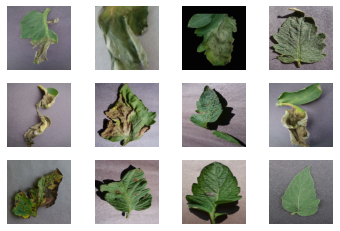

In [14]:
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        

In [15]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split==1)
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    

In [16]:
train_ds,val_ds,test_ds = get_dataset_partition_tf(dataset)

In [17]:
len(val_ds)

14

In [18]:
len(train_ds)

112

In [19]:
len(test_ds)

15

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
### Building the model  

In [22]:

# Layer for resizing and normalization 
#     before feeding the image to our model we are resizing the image because even though our input image are 256x256 but we can't
#     be sure if the user enters the image of size 256x256
    
#     we are also normalizing the pixle value between 0 to 1 
#     if we normalize the dataset, we can train the model efficiently with lower computing cost
#     cause each pixle value is between 1 to 255 while traning these value will get multiplied with some weight 
#     and might lead to huge value which lead to huge computation cost 


In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [24]:
# Layer for data augmentation 
#     this is needed when we have lesser data this boosts the accuracy of our model by augmenting the data.

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [26]:
# applying data augmentation on train ds

In [27]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
112/112 [==============================] - 397s 4s/step - loss: 0.6382 - accuracy: 0.7312 - val_loss: 0.7276 - val_accuracy: 0.7433
Epoch 2/50
112/112 [==============================] - 391s 3s/step - loss: 0.3894 - accuracy: 0.8337 - val_loss: 0.4671 - val_accuracy: 0.8326
Epoch 3/50
112/112 [==============================] - 392s 3s/step - loss: 0.3491 - accuracy: 0.8499 - val_loss: 0.3519 - val_accuracy: 0.8616
Epoch 4/50
112/112 [==============================] - 391s 3s/step - loss: 0.3276 - accuracy: 0.8600 - val_loss: 0.2334 - val_accuracy: 0.8973
Epoch 5/50
112/112 [==============================] - 387s 3s/step - loss: 0.3004 - accuracy: 0.8785 - val_loss: 0.3670 - val_accuracy: 0.8705
Epoch 6/50
112/112 [==============================] - 387s 3s/step - loss: 0.2851 - accuracy: 0.8833 - val_loss: 0.2375 - val_accuracy: 0.9062
Epoch 7/50
112/112 [==============================] - 386s 3s/step - loss: 0.2565 - accuracy: 0.8964 - val_loss: 0.4563 - val_accuracy: 0.8527